# Plot Cluster DMGs

In [1]:
import pandas as pd
import anndata
import matplotlib.pyplot as plt

from ALLCools.plot import *
from ALLCools.mcds import MCDS

In [2]:
adata_path = '../step_by_step/100kb/adata.with_coords.h5ad'
cluster_col = 'L1'

downsample = 30000

mc_type = 'CHN'
coord_base = 'tsne'

cluster_dmg_path = 'L1.OneVsRestDMG.hdf'

## Load

### Clustering results

In [3]:
adata = anndata.read_h5ad(adata_path)

# downsample cells when plot - to use less memory
if downsample and (adata.n_obs > downsample):
    use_cells = adata.obs.sample(downsample, random_state=0).index
    adata = adata[adata.obs_names.isin(use_cells), :].copy()
else:
    use_cells = adata.obs_names

## Cluster DMGs

In [4]:
cluster_dmgs = pd.read_hdf(cluster_dmg_path)
cluster_dmgs.head()

,pvals_adj,fc,AUROC,cluster
names,,,,
ENSMUSG00000023079,1.532981e-15,0.148641,0.996777,c13
ENSMUSG00000027692,1.532981e-15,0.498391,0.995703,c13
ENSMUSG00000004633,1.532981e-15,0.450733,0.994531,c13
ENSMUSG00000027508,1.532981e-15,0.343717,0.992578,c13
ENSMUSG00000035067,1.532981e-15,0.306569,0.991797,c13


## Gene mC Fraction Data

In [6]:
gene_meta = pd.read_csv(f'GeneMetadata.csv.gz', index_col=0)
gene_name_to_gene_id = {v: k for k, v in gene_meta['gene_name'].items()}
gene_meta.index.name = 'gene_id'

gene_frac_da = MCDS.open(f'geneslop2k-vm23_frac.mcds/',
                         use_obs=use_cells)[f'geneslop2k-vm23_da_frac']
gene_frac_da = gene_frac_da.sel(mc_type=mc_type).load()
gene_frac_da

<xarray.DataArray 'geneslop2k-vm23_da_frac' (cell: 4875, geneslop2k-vm23: 32208)>
array([[0.60969174, 0.46467954, 0.3158004 , ..., 0.2951378 , 0.431459  ,
        0.4855843 ],
       [0.6827333 , 0.93142   , 0.5549902 , ..., 0.38427612, 0.34739572,
        0.37083265],
       [0.76935685, 0.93355936, 0.5213342 , ..., 2.5879016 , 2.4208999 ,
        2.6841462 ],
       ...,
       [1.0065095 , 0.6231023 , 0.34672394, ..., 1.        , 1.        ,
        1.        ],
       [1.2884517 , 1.3856478 , 1.0957903 , ..., 1.1338042 , 0.6558095 ,
        0.6558095 ],
       [0.79113954, 1.2763032 , 0.646672  , ..., 0.4655836 , 0.51936275,
        0.41447762]], dtype=float32)
Coordinates:
  * cell                      (cell) <U15 '8E_M_3022' ... '8J_M_2288'
  * geneslop2k-vm23           (geneslop2k-vm23) <U18 'ENSMUSG00000051951' ......
    geneslop2k-vm23_cov_mean  (geneslop2k-vm23) float64 6.996e+03 ... 529.6
    mc_type                   <U3 'CHN'

## Plot

In [9]:
def get_gene_values_by_name(gene_name):
    data = gene_frac_da.sel({'geneslop2k-vm23': gene_name_to_gene_id[gene_name]}).to_pandas()
    data.name = gene_name
    return data

### Plot Single Gene

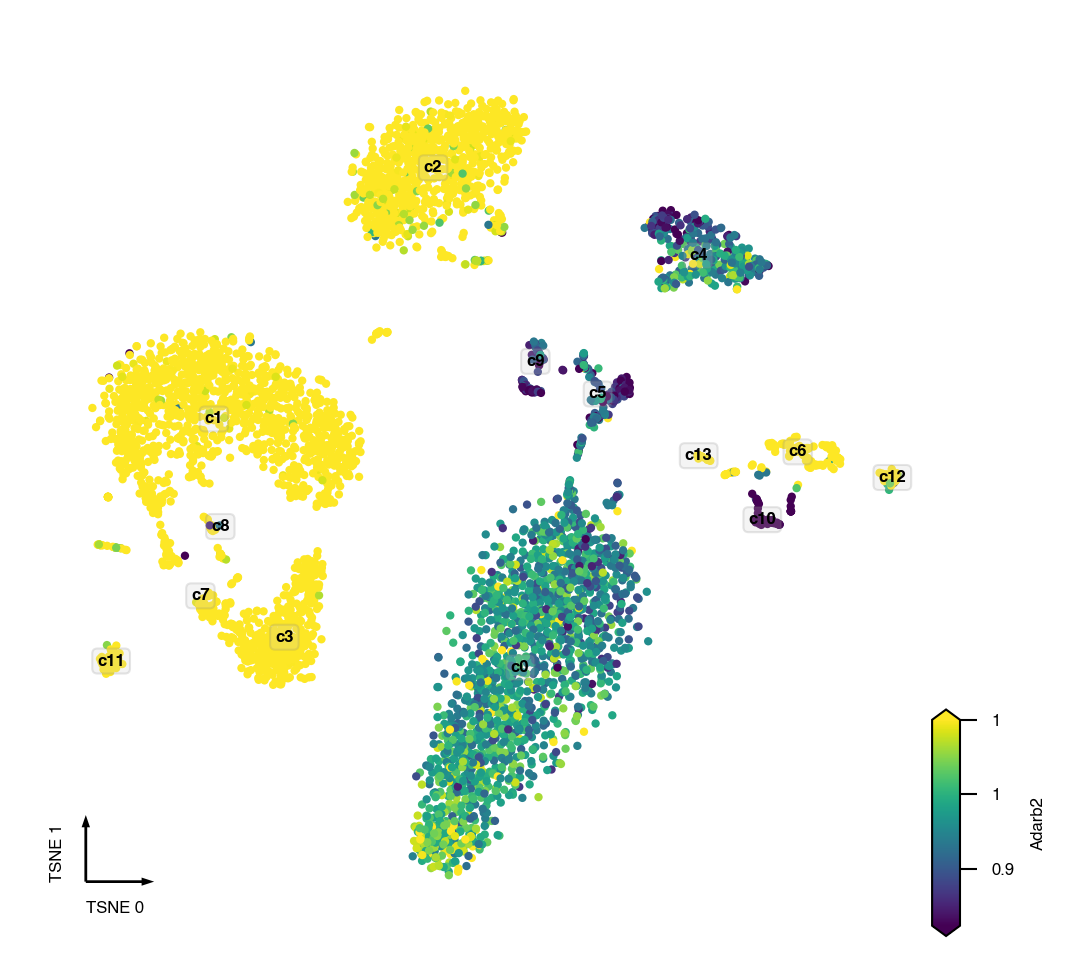

In [10]:
gene = 'Adarb2'
hue_norm = (0.67, 1.5)
coord_base = 'tsne'

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

_ = continuous_scatter(ax=ax,
                       data=adata.obs,
                       hue=get_gene_values_by_name(gene),
                       hue_norm=hue_norm,
                       text_anno=cluster_col,
                       coord_base=coord_base,
                       max_points=None,
                       s=4)

### Plot Cluster Top Markers

In [11]:
def plot_cluster_and_genes(cluster, cell_meta, cluster_col, genes_data,
                           coord_base='umap', ncols=5, axes_size=3, dpi=150, hue_norm=(0.67, 1.5)):
    ncols = max(2, ncols)
    nrows = 1 + (genes_data.shape[1] - 1) // ncols + 1

    # figure
    fig = plt.figure(figsize=(ncols * axes_size, nrows * axes_size), dpi=dpi)
    gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

    # cluster axes
    ax = fig.add_subplot(gs[0, 0])
    categorical_scatter(data=cell_meta,
                        ax=ax,
                        coord_base=coord_base,
                        axis_format=None,
                        hue=cluster_col,
                        palette='tab20')
    ax.set_title('All Clusters')
    ax = fig.add_subplot(gs[0, 1])
    categorical_scatter(data=cell_meta,
                        ax=ax,
                        coord_base=coord_base,
                        hue=cell_meta[cluster_col] == cluster,
                        axis_format=None,
                        palette={
                            True: 'red',
                            False: 'lightgray'
                        })
    ax.set_title('This Cluster')

    # gene axes
    for i, (gene, data) in enumerate(genes_data.iteritems()):
        col = i % ncols
        row = i // ncols + 1
        ax = fig.add_subplot(gs[row, col])

        if ax.get_subplotspec().is_first_col() and ax.get_subplotspec().is_last_row():
            axis = 'tiny'
        else:
            axis = None

        continuous_scatter(ax=ax,
                           data=cell_meta,
                           hue=data,
                           axis_format=axis,
                           hue_norm=hue_norm,
                           coord_base=coord_base)
        ax.set_title(f'{data.name}')
    fig.suptitle(f'Cluster {cluster} Top Markers')
    return fig

### Per Cluster Plots

In [12]:
cluster_dmgs.head()

,pvals_adj,fc,AUROC,cluster
names,,,,
ENSMUSG00000023079,1.532981e-15,0.148641,0.996777,c13
ENSMUSG00000027692,1.532981e-15,0.498391,0.995703,c13
ENSMUSG00000004633,1.532981e-15,0.450733,0.994531,c13
ENSMUSG00000027508,1.532981e-15,0.343717,0.992578,c13
ENSMUSG00000035067,1.532981e-15,0.306569,0.991797,c13


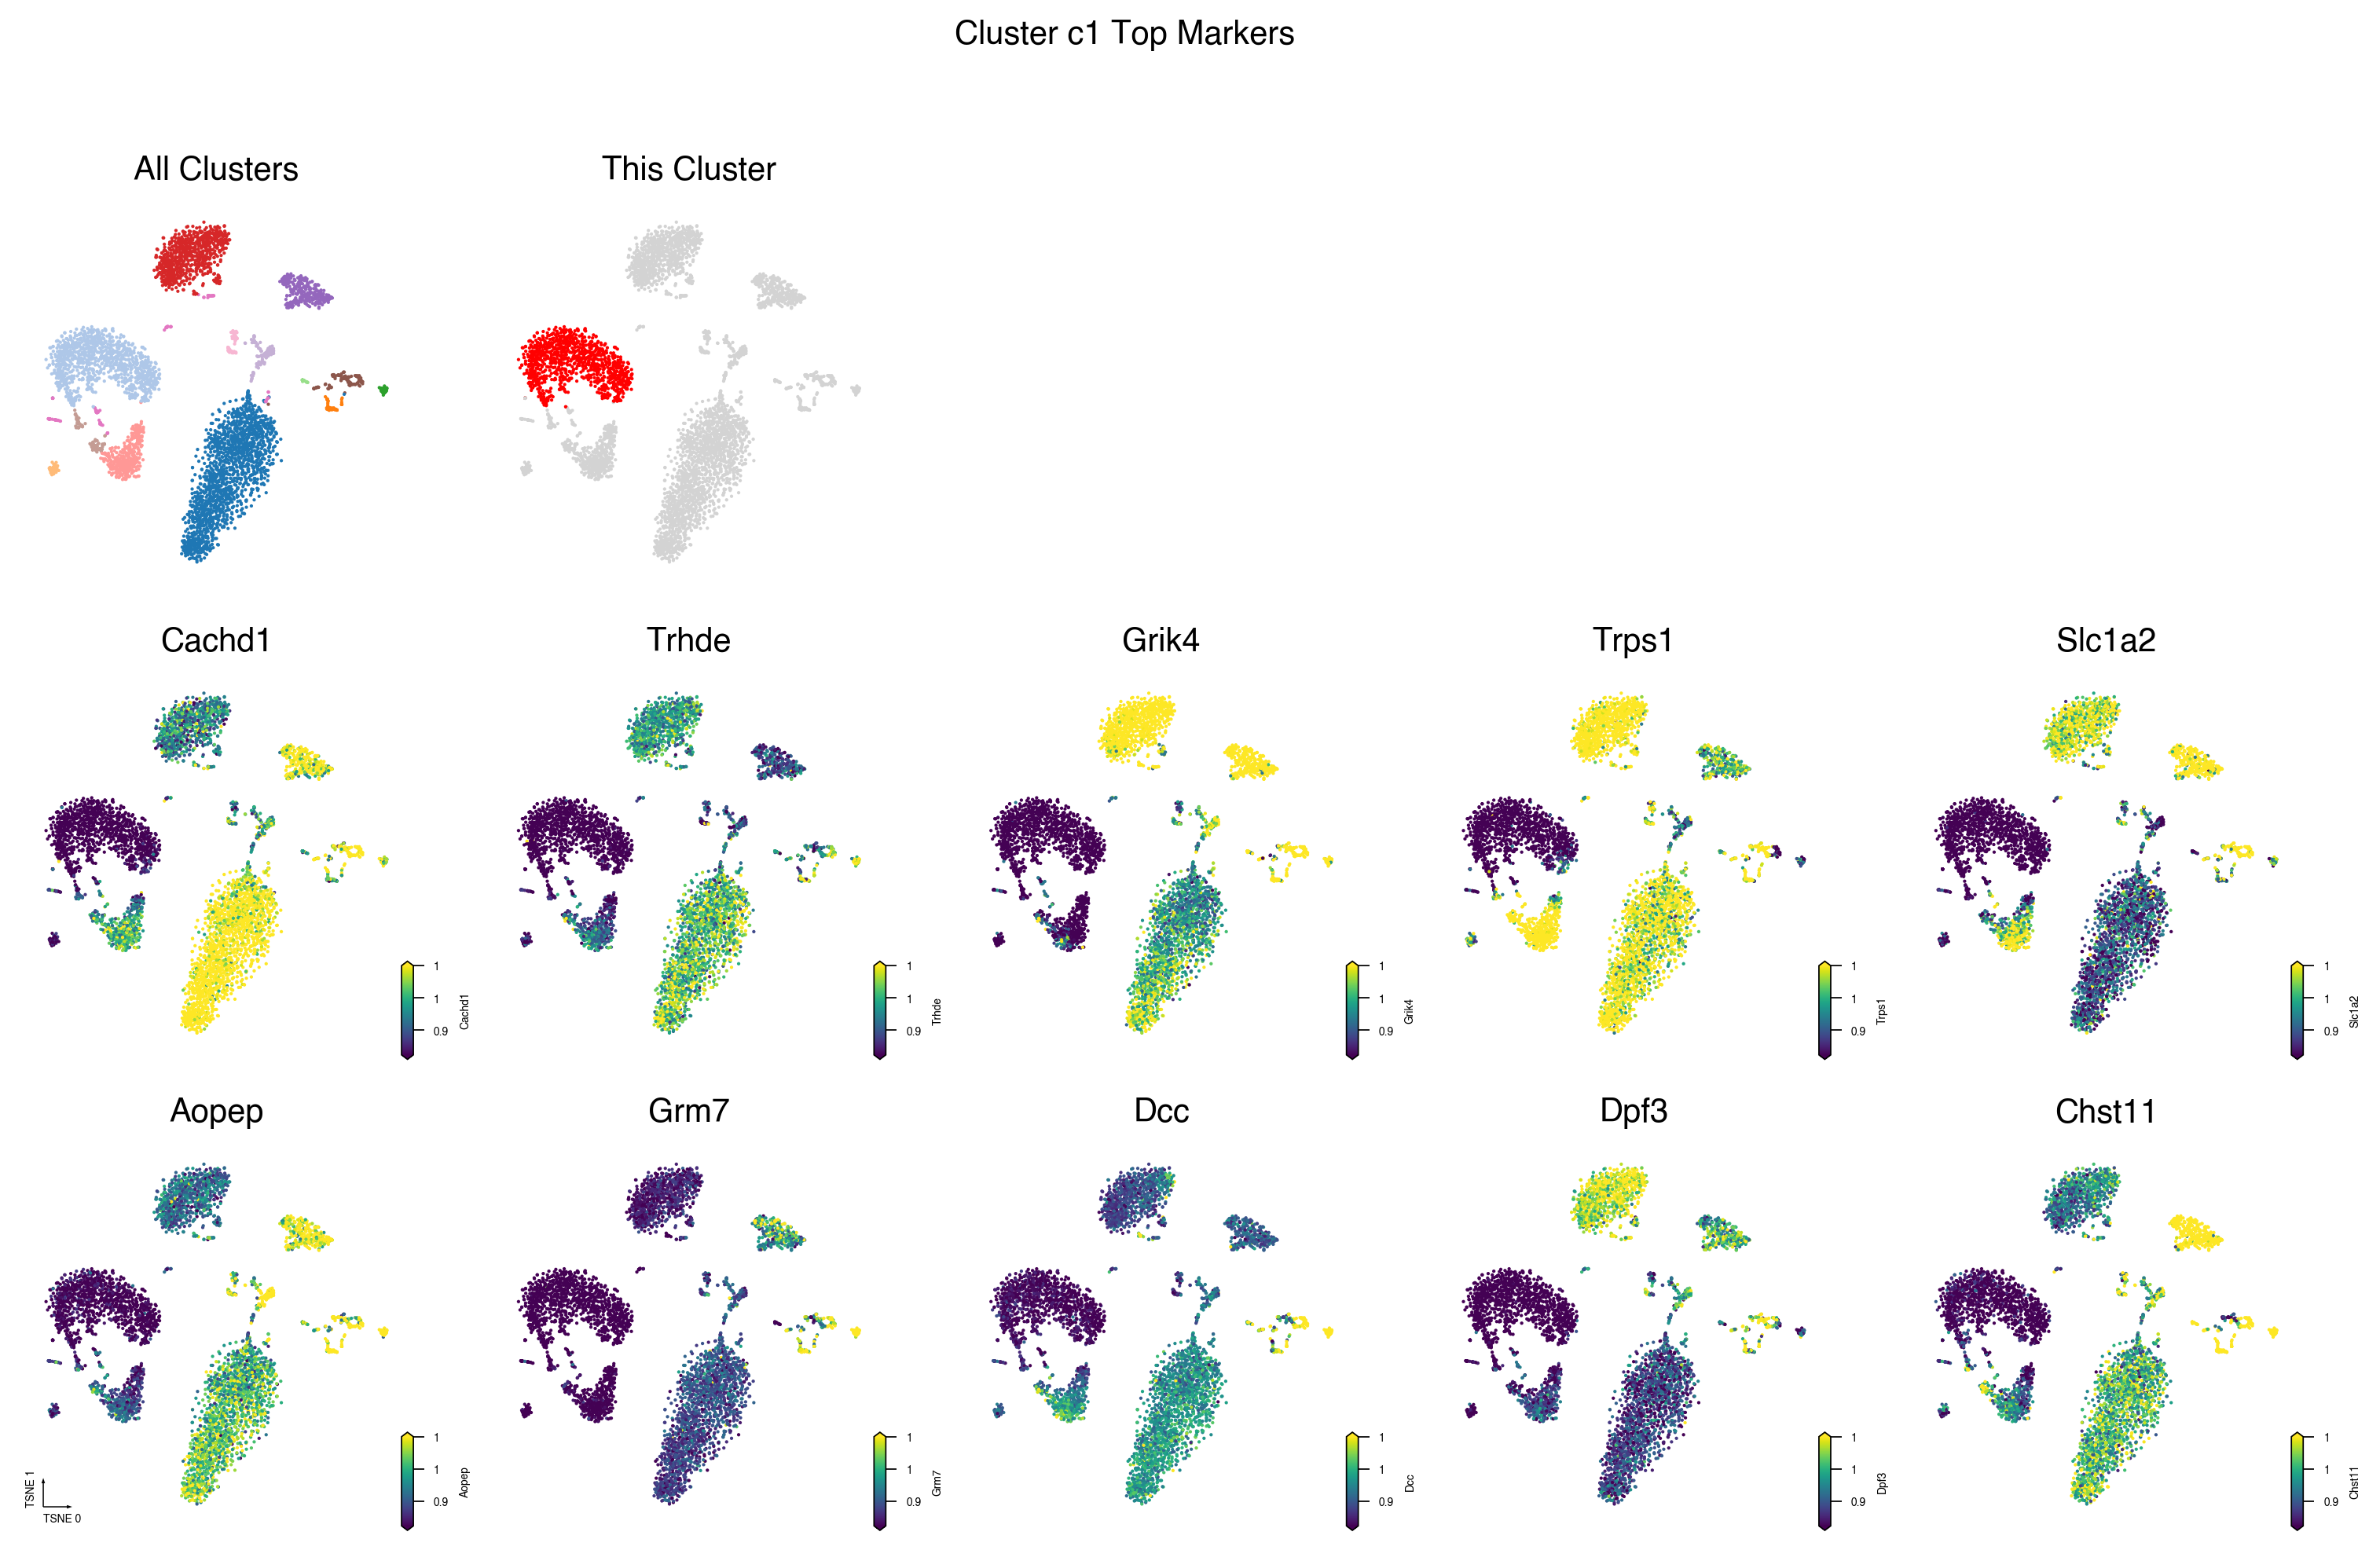

In [14]:
cluster = 'c1'
genes = cluster_dmgs[cluster_dmgs['cluster'] == cluster].sort_values(
    'AUROC', ascending=False)[:10]
genes_data = gene_frac_da.sel({'geneslop2k-vm23': genes.index}).to_pandas()
genes_data.columns = genes_data.columns.map(gene_meta['gene_name'])

fig = plot_cluster_and_genes(cluster=cluster,
                             cell_meta=adata.obs,
                             cluster_col=cluster_col,
                             genes_data=genes_data,
                             coord_base='tsne',
                             ncols=5,
                             axes_size=3,
                             dpi=250,
                             hue_norm=(0.67, 1.5))

fig.savefig(f'{cluster}.TopMarker.png', bbox_inches='tight')